In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
import seaborn as sns
from model import loss
from model import reverse_se3_diffusion
import tree
import mdtraj as md
from openfold.np.relax import amber_minimize
from data import rosetta_data_loader
from data import digs_data_loader
from data import all_atom
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from openfold.np import residue_constants
from scipy.spatial.transform import Rotation

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
INFO: Using numpy backend


SyntaxError: invalid syntax (train_se3_diffusion.py, line 400)

In [ ]:
# Set environment variables for which GPUs to use.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
chosen_gpu = ''.join(
    [str(x) for x in GPUtil.getAvailable(order='memory')])
os.environ["CUDA_VISIBLE_DEVICES"] = chosen_gpu
print(f"Using GPU: {chosen_gpu}")

In [ ]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(au)
importlib.reload(all_atom)
importlib.reload(plotting)
importlib.reload(loss)
importlib.reload(reverse_se3_diffusion)
importlib.reload(inference_se3_diffusion)
importlib.reload(train_se3_diffusion)

## Trial different metrics

In [ ]:
# Load model
inference_conf_path = '../config/inference.yaml'
inference_conf = OmegaConf.load(inference_conf_path)
# inference_conf.ckpt_dir = '../pkl_jar/ckpt/subset_100_psi_joint_09D_09M_2022Y_05h_36m_56s'
inference_conf.ckpt_dir = '../pkl_jar/ckpt/subset_1_psi_stop_exp_lin_09D_09M_2022Y_05h_43m_26s'
inference_conf.default_conf_path = '../config/base.yaml'
inference_conf.output_dir = '../results'

print(OmegaConf.to_yaml(inference_conf))

# Set up sampler
sampler = inference_se3_diffusion.Sampler(inference_conf)

In [ ]:
train_loader, valid_loader = sampler.exp.create_rosetta_dataset(0, 1)
train_csv = train_loader.dataset.csv

In [ ]:
train_csv.head()

In [ ]:
# Run sampler
batch_size = 1
num_res = 207
save = True
samples_traj = sampler.sample(batch_size, num_res, save=save)

In [ ]:
# Set up MDTraj
pdb_path = '../results/test_data/1qys.pdb'
pdb_path = '../results/subset_1_psi_stop_exp_lin_09D_09M_2022Y_05h_43m_26s/len_207_bb_3.pdb'
# pdb_path = '../results/subset_100_psi_joint_09D_09M_2022Y_05h_36m_56s/len_152_bb_4.pdb'
traj = md.load(pdb_path)
# SS percentage
pdb_ss = md.compute_dssp(traj, simplified=True)
pdb_ss_percent = np.mean(pdb_ss != 'C')
# Radius of gyration
pdb_rg = md.compute_rg(traj)

In [ ]:
prot_traj = samples_traj[1]
atom37_pos = du.move_to_np(prot_traj[0, -1])
atom37_mask = np.any(atom37_pos, axis=-1)

In [ ]:
# TODO: Create protein object then violation metrics.
prot = au.create_full_prot(atom37_pos, atom37_mask)
violation_metrics = amber_minimize.get_violation_metrics(prot)

In [ ]:
struct_violations = violation_metrics['structural_violations']
inter_violations = struct_violations['between_residues']
intra_violations = struct_violations['within_residues']

In [63]:
inter_violation_metrics = [
    'bonds_c_n_loss_mean',
    'angles_ca_c_n_loss_mean',
    'angles_c_n_ca_loss_mean',
    'clashes_mean_loss',
]

intra_violation_metrics = [
    'per_atom_loss_sum',
    'per_atom_violations',
]

In [1]:
inter_violation_metrics

NameError: name 'inter_violation_metrics' is not defined

## Set-up validation set

In [76]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False
exp_conf.normalize_pred_score = True

data_conf = conf.data

diff_conf = conf.diffuser
diff_conf.diffuse_trans = True
diff_conf.diffuse_rot = True

diff_conf.rot_schedule = 'linear'
diff_conf.trans_schedule = 'exponential'

# print(OmegaConf.to_yaml(conf))

In [77]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)

INFO: Number of model parameters 3685920
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Training: 18769 examples
INFO: Validation: 18769 examples


In [83]:
train_loader.dataset.csv.modeled_seq_len.value_counts()

129    961
257    617
223    524
162    406
258    395
      ... 
72      14
68      13
78      12
63      11
70       8
Name: modeled_seq_len, Length: 201, dtype: int64

In [93]:
train_loader.dataset.csv.mmseqs_cluster.value_counts()

25       964
18       949
6        853
98       539
146      412
        ... 
33867      1
30895      1
25461      1
32204      1
19740      1
Name: mmseqs_cluster, Length: 4106, dtype: int64

In [100]:
train_loader.dataset.csv.mmseqs_cluster.fillna(-1)

0          555
8         9751
15         174
22         768
28         105
          ... 
144703     118
144731      98
144733      98
144734      98
144735     146
Name: mmseqs_cluster, Length: 18769, dtype: object

<AxesSubplot:>

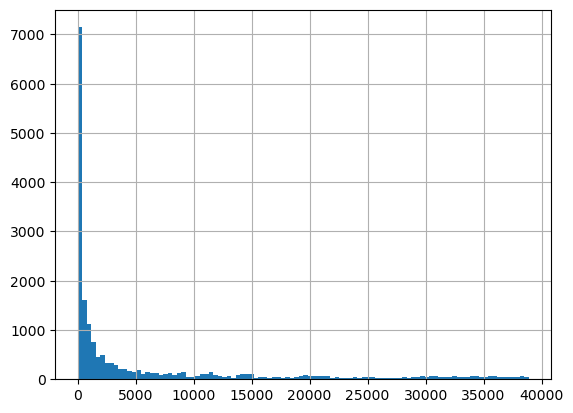

In [102]:
train_loader.dataset.csv.mmseqs_cluster.fillna(-1).map(int).hist(bins=100)

In [ ]:
train_loader.dataset.csv.mmseqs_cluster.fillna(-1).

<AxesSubplot:>

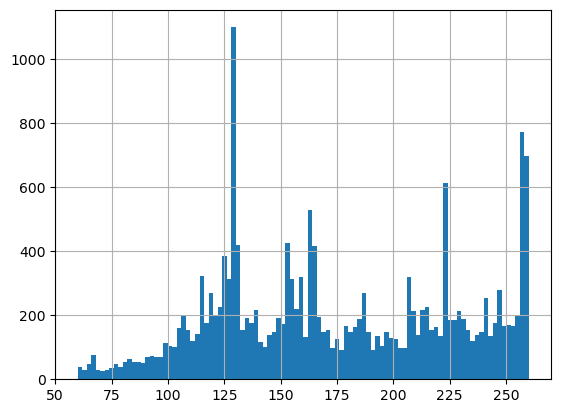

In [85]:
train_loader.dataset.csv.modeled_seq_len.hist(bins=100)

In [3]:
base_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/data/cath'
cath_domain_file = os.path.join(base_dir, 'cath-domain-list.txt')
cath_nr40_file = os.path.join(base_dir, 'cath-dataset-nonredundant-S40.list')

In [4]:
with open(cath_nr40_file) as f:
    cath_nr40_ids = f.read().split('\n')[:-1]
cath_nr40_chains = list(set(cath_id[:5] for cath_id in cath_nr40_ids))
chain_set = sorted([(name[:4], name[4]) for name in  cath_nr40_chains])

cath_nodes = defaultdict(list)
with open(cath_domain_file,'r') as f:
    lines = [line.strip() for line in f if not line.startswith('#')]
    for line in lines:
        entries = line.split()
        cath_id, cath_node = entries[0], '.'.join(entries[1:4])
        chain_name = cath_id[:4] + '.' + cath_id[4]
        cath_nodes[chain_name].append(cath_node)
cath_nodes = {key:list(set(val)) for key,val in cath_nodes.items()}

In [8]:
import pandas as pd

In [11]:
cath_dir = '/data/rsg/chemistry/jyim/large_data/cath'
cath_csv_path = os.path.join(cath_dir, 'metadata.csv')

In [26]:
cath_csv = pd.read_csv(cath_csv_path)

In [29]:
cath_csv[cath_csv.cath_code == "['3.40.50']"]

,chain_name,cath_code,cath_split,processed_path,raw_path,oligomeric_count,oligomeric_detail,resolution,structure_method,num_chains,seq_len,modeled_seq_len,coil_percent,helix_percent,strand_percent,radius_gyration
1105,4nav.A,['3.40.50'],train,/data/rsg/chemistry/jyim/large_data/cath/na/4n...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,"4,4","tetrameric,tetrameric",2.69,x-ray diffraction,4,190,181,0.453039,0.408840,0.138122,[1.56458876]
1107,4uhc.A,['3.40.50'],train,/data/rsg/chemistry/jyim/large_data/cath/uh/4u...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.03,x-ray diffraction,1,716,278,0.323741,0.496403,0.179856,[1.81761436]
1110,3m2p.A,['3.40.50'],train,/data/rsg/chemistry/jyim/large_data/cath/m2/3m...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,"2,2,2","dimeric,dimeric,dimeric",2.95,x-ray diffraction,6,314,287,0.400697,0.393728,0.205575,[1.95616136]
1112,3bje.A,['3.40.50'],train,/data/rsg/chemistry/jyim/large_data/cath/bj/3b...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,2,dimeric,1.44,x-ray diffraction,2,563,327,0.382263,0.354740,0.262997,[2.01599164]
1114,3lp5.A,['3.40.50'],train,/data/rsg/chemistry/jyim/large_data/cath/lp/3l...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,2.00,x-ray diffraction,1,406,250,0.420000,0.376000,0.204000,[1.72581546]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18968,1shu.X,['3.40.50'],train,/data/rsg/chemistry/jyim/large_data/cath/sh/1s...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,1,monomeric,1.50,x-ray diffraction,1,336,181,0.292818,0.475138,0.232044,[1.53445842]
18970,1r1d.A,['3.40.50'],train,/data/rsg/chemistry/jyim/large_data/cath/r1/1r...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,2,dimeric,1.90,x-ray diffraction,2,549,242,0.396694,0.462810,0.140496,[1.83645909]
18982,2yfk.A,['3.40.50'],train,/data/rsg/chemistry/jyim/large_data/cath/yf/2y...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,"3,3","trimeric,trimeric",2.55,x-ray diffraction,2,413,385,0.329870,0.524675,0.145455,[2.1336157]
18985,3n74.A,['3.40.50'],train,/data/rsg/chemistry/jyim/large_data/cath/n7/3n...,/data/rsg/chemistry/jyim/large_data/pdb/30_08_...,4,tetrameric,2.20,x-ray diffraction,4,377,227,0.348018,0.484581,0.167401,[1.72441555]


In [28]:
cath_csv.cath_code.value_counts()

['3.40.50']                          2226
['2.60.40']                           944
['3.20.20']                           537
['2.60.120']                          515
['3.30.70']                           503
                                     ... 
['2.30.30', '3.40.50', '2.30.42']       1
['4.10.1050']                           1
['6.10.30', '3.90.226']                 1
['2.30.30', '3.40.630']                 1
['3.30.499']                            1
Name: cath_code, Length: 2140, dtype: int64